In [1]:
import numpy as np
from matplotlib import pyplot as plt
import librosa
import os
import sklearn.preprocessing
from scipy.signal import lfilter, spectrogram, stft
from scipy.fft import rfft, dct

In [2]:
working_dir = os.getcwd()

In [3]:
def get_spectrum(x, fs, N, f_scale='Hz'):
    X = abs(np.fft.fft(x, N))
    X = X[0:N//2]
    f = np.fft.fftfreq(n = N, d = 1/fs)
    f = f[0:N//2]
    if f_scale == 'kHz':
        f = f/1000

    return X, f

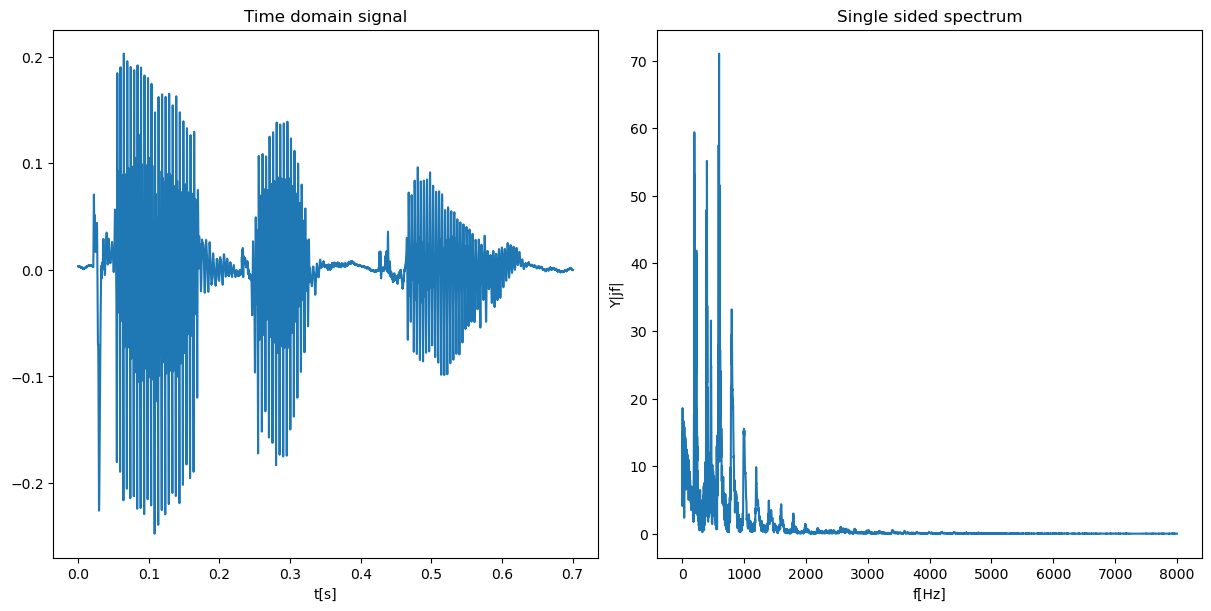

In [4]:
y, fs = librosa.load(os.path.join(working_dir, '..', 'Data','words', 'Speaker_4', 'word_0.wav'), sr=None)
N = len(y)
duration = N/fs
t = np.linspace(0,duration,N)

Y, f = get_spectrum(y, fs, N, f_scale='Hz')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs = ax.ravel()
axs[0].plot(t,y)
axs[0].title.set_text('Time domain signal')
axs[0].set_xlabel('t[s]')
axs[1].plot(f,Y)
axs[1].title.set_text('Single sided spectrum')
axs[1].set_xlabel('f[Hz]')
axs[1].set_ylabel('Y|jf|')

plt.show()

#### Pre-emphasis

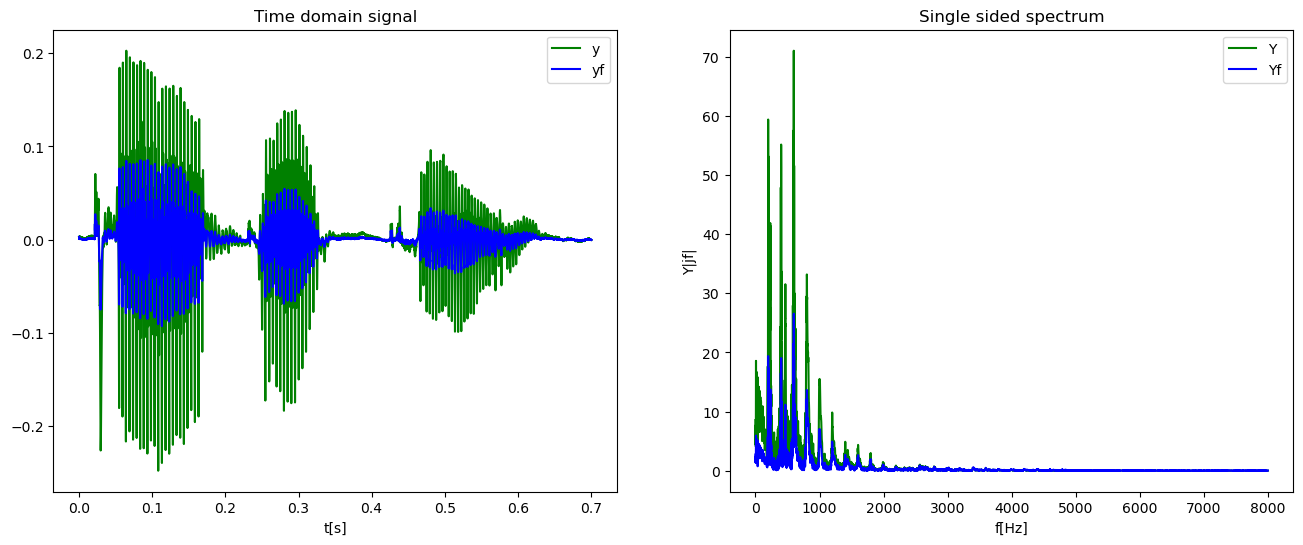

In [5]:
yf = lfilter(b=[1, -0.68], a=1, x=y)

Yf, f = get_spectrum(yf, fs, N, f_scale='Hz')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
axs = ax.ravel()
axs[0].plot(t,y, color='green', label='y')
axs[0].plot(t,yf, color='blue', label='yf')
axs[0].title.set_text('Time domain signal')
axs[0].set_xlabel('t[s]')
axs[0].legend()

axs[1].plot(f,Y, color='green', label='Y')
axs[1].plot(f,Yf, color='blue', label='Yf')
axs[1].title.set_text('Single sided spectrum')
axs[1].set_xlabel('f[Hz]')
axs[1].set_ylabel('Y|jf|')
axs[1].legend()
plt.show()

### MFCC extraction using librosa

In [6]:
window_length = int(30*fs/1000) #30ms window
window_step = int(20*fs/1000) #20ms step

In [33]:
mfccs = librosa.feature.mfcc(y=yf, n_mfcc=20,sr=fs, win_length=window_length, hop_length=window_step, window = np.hanning(window_length))
print(mfccs.shape)

(20, 36)


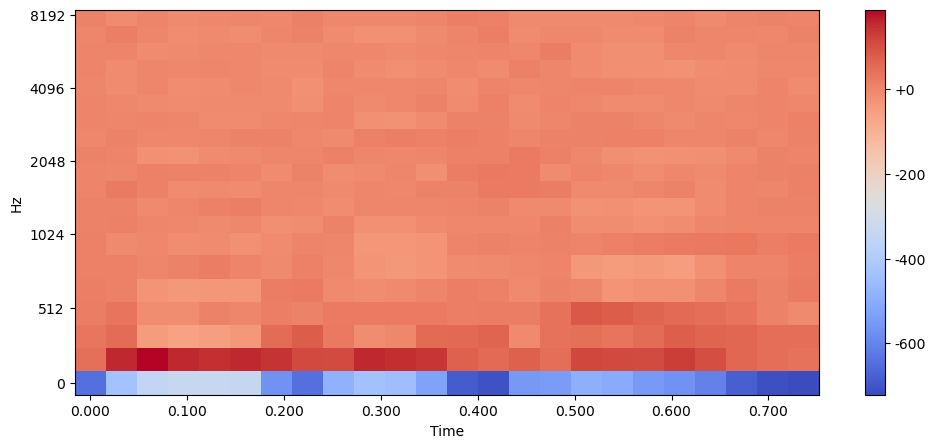

In [32]:
plt.figure(figsize=(12, 5))
librosa.display.specshow(mfccs, 
                         x_axis="time", 
                         y_axis='mel',
                         sr=fs)
plt.colorbar(format="%+2.f")
plt.show()

### Extracting MFCCs manually (for one window)

#### Windowing a signal

In [9]:
frames = librosa.util.frame(yf, frame_length=window_length, hop_length=window_step)
frames.shape

(480, 34)

In [10]:
windowed_frames = np.hanning(window_length).reshape(-1,1)*frames

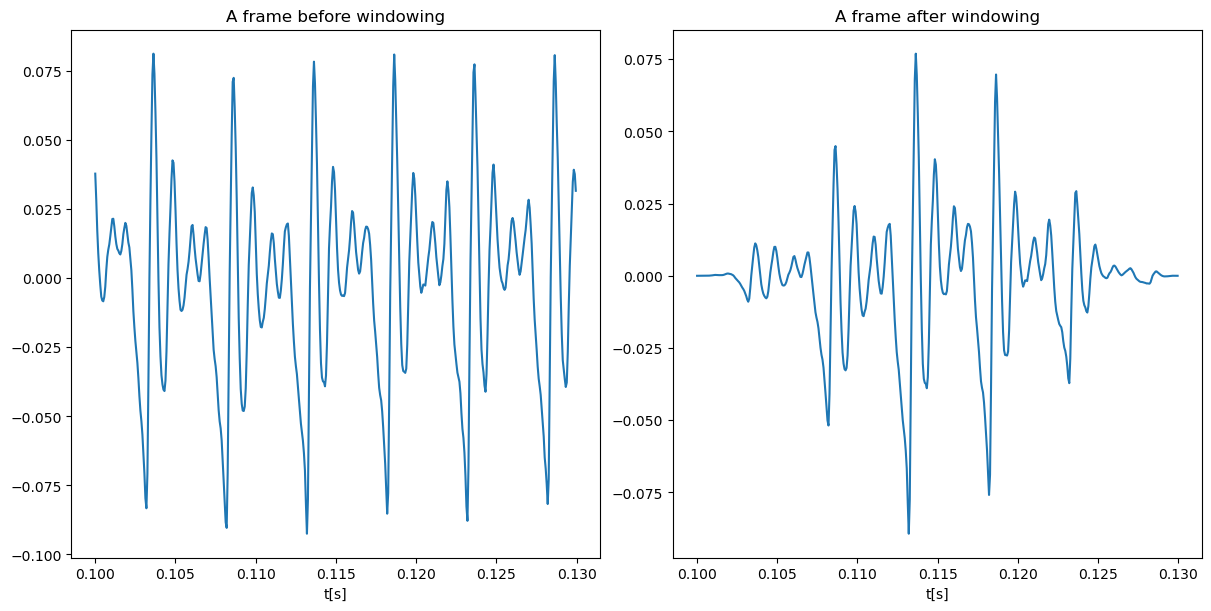

In [15]:
example_frame_num = 5
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,6),
                       layout='constrained')
axs = ax.ravel()
axs[0].plot(t[example_frame_num*window_step:example_frame_num*window_step+window_length],frames[:,example_frame_num])
axs[0].title.set_text('A frame before windowing')
axs[0].set_xlabel('t[s]')
axs[1].plot(t[example_frame_num*window_step:example_frame_num*window_step+window_length], windowed_frames[:,example_frame_num])
axs[1].title.set_text('A frame after windowing')
axs[1].set_xlabel('t[s]')
plt.show()

#### Cepstrum

In [16]:
# Time-domain signal
window = windowed_frames[:,example_frame_num]
t_window = np.linspace(0,20,window_length)

# Spectrum
N_window = window_length
window_spectrum, f_window = get_spectrum(window, fs, N_window, f_scale='kHz')



# Log-spectrum
logspectrum = 20*np.log10(window_spectrum)

# Cepstrum
cepstrum = abs(np.fft.fft(logspectrum))
cepstrum = cepstrum[0:N_window//2]
ctime = np.linspace(0,0.5*1000*N_window/fs,len(cepstrum))


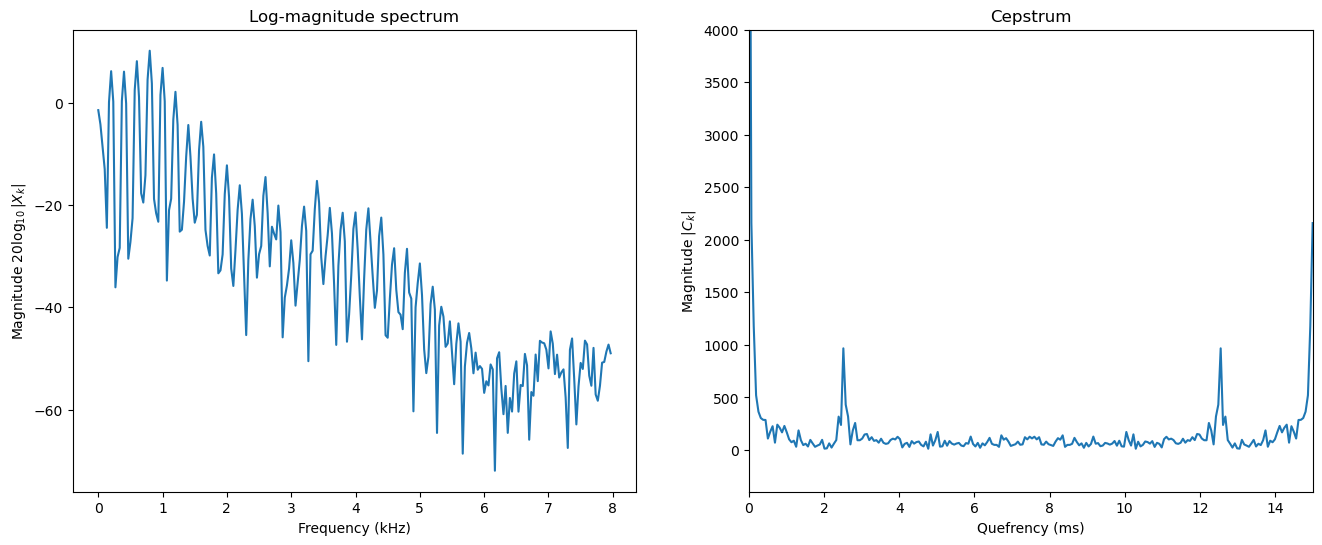

In [17]:
plt.figure(figsize=[16,6])

plt.subplot(121)
plt.plot(f_window,logspectrum)
plt.title('Log-magnitude spectrum')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude $20\log_{10}|X_k|$')

plt.subplot(122)
plt.plot(ctime,cepstrum)
plt.title('Cepstrum')
plt.xlabel('Quefrency (ms)')
plt.ylabel('Magnitude $|C_k|$')
ax = plt.axis()
ax = [0, 15, ax[2], 4000]
plt.axis(ax)

plt.show()


#### Mel-scale

In [18]:
def freq2mel(f): return 2595*np.log10(1 + (f/700))
def mel2freq(m): return 700*(10**(m/2595) - 1)

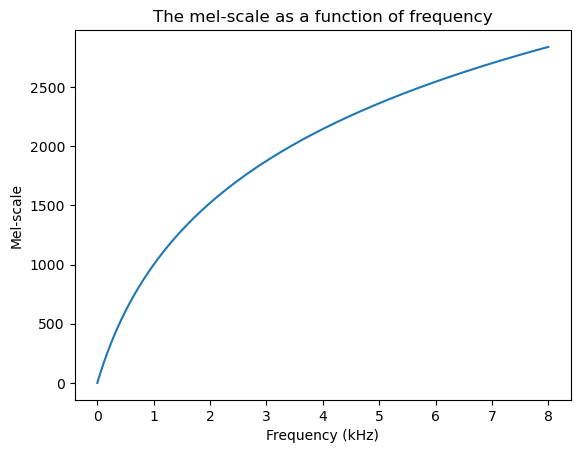

In [19]:
freq = np.linspace(0,8000,1000)

fig, ax = plt.subplots()
ax.plot(freq/1000,freq2mel(freq))
ax.set_xlabel('Frequency (kHz)')
ax.set_ylabel('Mel-scale')
ax.title.set_text('The mel-scale as a function of frequency')
plt.show()

In [20]:
def get_melbank(melbands, maxmel, f, spectrum_len):
    mel_idx = np.linspace(0,maxmel,melbands+2)
    freq_idx = mel2freq(mel_idx)
    k = f*1000
    melfilterbank = np.zeros((spectrum_len,melbands))

    for j in range(1,melbands):
        l_j = freq_idx[j-1]
        c_j = freq_idx[j]
        u_j = freq_idx[j+1]
        upslope = (k-l_j)/(c_j-l_j)
        downslope = (u_j-k)/(u_j-c_j)

        if j==1:
            upslope = 1.0 + 0*k
        if j==melbands-1:
            downslope = 1.0 + 0*k

        melfilterbank[:,j-1] = np.max([0*k,np.min([upslope,downslope],axis=0)],axis=0)

    melreconstruct = np.matmul(np.diag(np.sum(melfilterbank**2+1e-12,axis=0)**-1),np.transpose(melfilterbank))
    return melfilterbank, melreconstruct

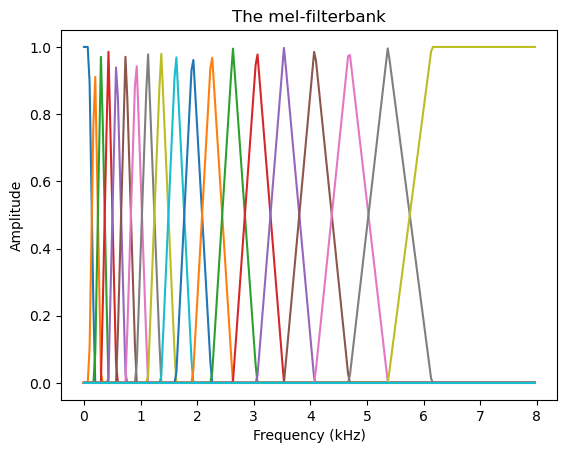

In [21]:
melbands = 20
maxmel = freq2mel(8000)
melfilterbank, melreconstruct = get_melbank(melbands, maxmel, spectrum_len=len(window_spectrum),f=f_window)

plt.figure()
plt.plot(f_window,melfilterbank)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('The mel-filterbank')
plt.show()

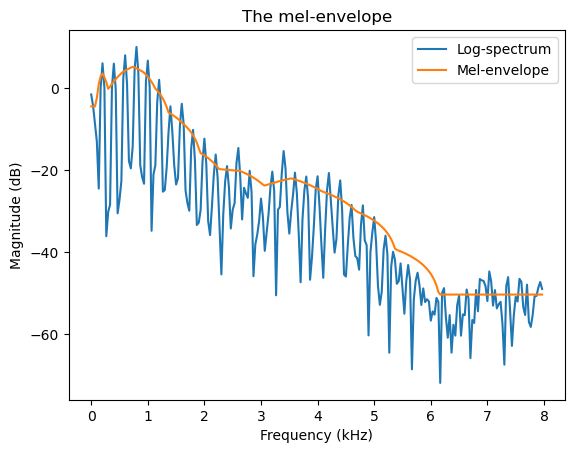

In [22]:
logmelspectrum = 10*np.log10(np.matmul(np.transpose(melfilterbank),np.abs(window_spectrum)**2)+1e-12)
logenvelopespectrum = 10*np.log10(np.matmul(np.transpose(melreconstruct),10**(logmelspectrum/10)))

plt.plot(f_window,logspectrum,label='Log-spectrum')
plt.plot(f_window,logenvelopespectrum,label='Mel-envelope')
plt.legend()
plt.xlabel('Frequency (kHz)')
plt.ylabel('Magnitude (dB)')
plt.title('The mel-envelope')
plt.show()

#### MFCC
A remaining issue with the log-melspectrum is however that neighbouring samples are highly correlated. That is, information is distributed throughout the individual samples. A generic operation for decorrelating sequentially correlated data is the discrete cosine transform (DCT)

In [23]:
mfcc = dct(logmelspectrum)

### MFCC extraction for whole signal

/tmp/ipykernel_52435/2578116765.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(t_spect, f_spect, 20*np.log10(np.abs(Sxx)), shading='gouraud')


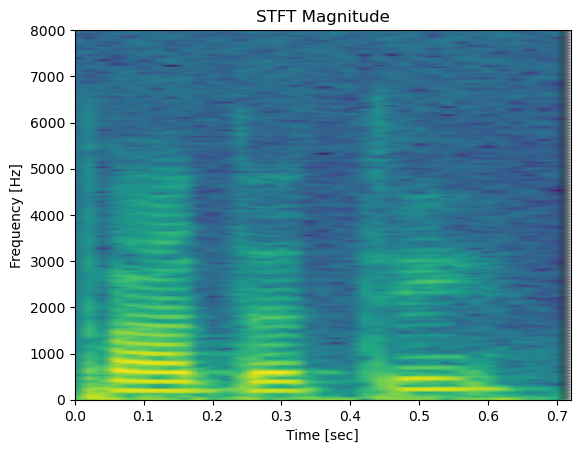

In [24]:
f_spect, t_spect, Sxx = stft(x=y,fs=fs,window='hann',nperseg=window_length,noverlap=window_length-window_step)
plt.pcolormesh(t_spect, f_spect, 20*np.log10(np.abs(Sxx)), shading='gouraud')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

In [25]:
melbands = 15
maxmel = freq2mel(8000)
melfilterbank, melreconstruct = get_melbank(melbands, maxmel, spectrum_len=Sxx.shape[0] ,f=f_spect/1000)

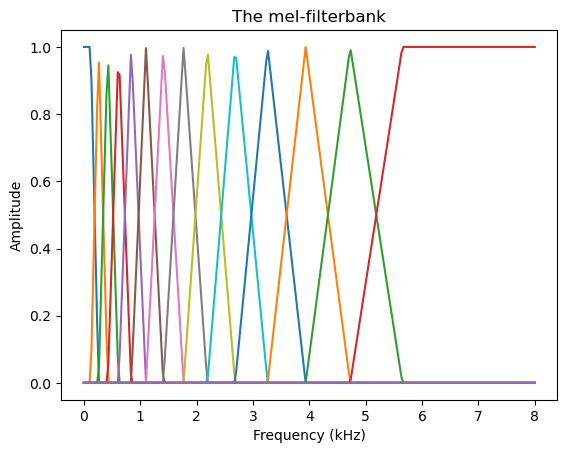

In [26]:
plt.figure()
plt.plot(f_spect/1000,melfilterbank)
plt.xlabel('Frequency (kHz)')
plt.ylabel('Amplitude')
plt.title('The mel-filterbank')
plt.show()

In [27]:
logmelspectrogram = np.log(np.matmul((np.abs(Sxx)**2).T,melfilterbank)+1e-12)
mfcc = dct(logmelspectrogram)

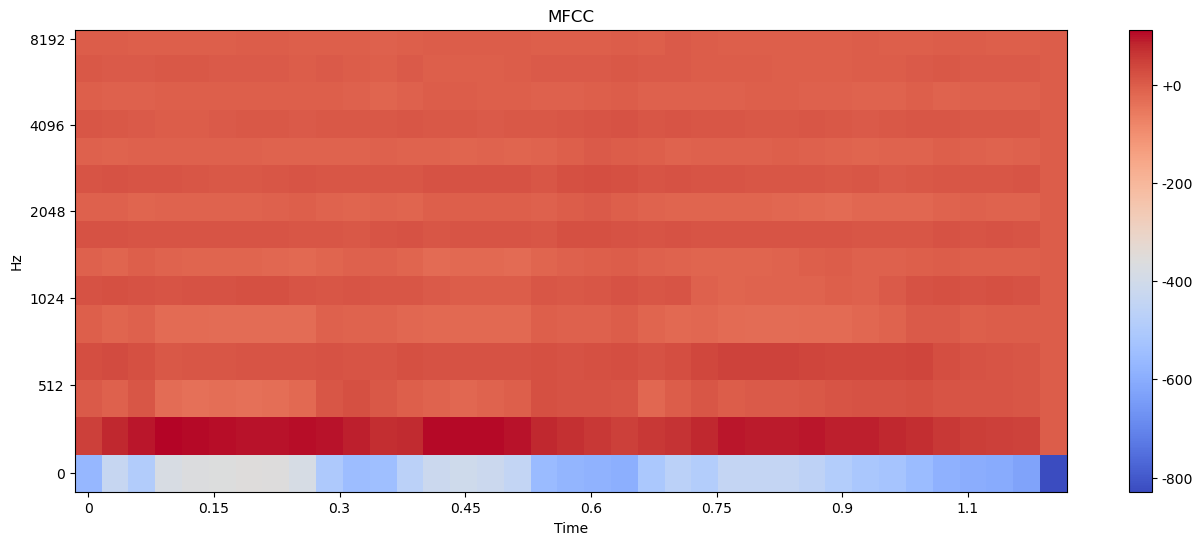

In [30]:
plt.figure(figsize=(16, 6))
librosa.display.specshow(mfcc.T, 
                         x_axis="time", 
                         y_axis='mel',
                         sr=fs)
plt.colorbar(format="%+2.f")
plt.title('MFCC')
plt.show()